# Link Prediction in NetworKit

## Setup

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random
from cython import *

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [3]:
def drawROC(indexName, predictions):
    X, Y = roc.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.legend(handles=[curve], loc=4)
def drawPR(indexName, predictions):
    X, Y = pr.getCurve(predictions)
    plt.suptitle(indexName, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    curve, = plt.plot(X, Y, label=indexName)
    plt.legend(handles=[curve])
def drawROCs(supTitle, **args):
    predictions = args["predictions"]
    indexNames = args["indexNames"]
    plt.suptitle(supTitle, fontsize=14, fontweight="bold")
    plt.xticks([z / 10 for z in range(11)])
    plt.yticks([z / 10 for z in range(11)])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], '#aaaaaa', ls='--')
    handles = []
    for i in range(0, len(indexNames)):
        X, Y = roc.getCurve(predictions[i])
        curve, = plt.plot(X, Y, label=indexNames[i])
        handles.append(curve)
    plt.legend(handles=handles, loc=4, fontsize=10)

## Choose graph

In [4]:
#testGraph, trainingGraph = linkprediction.readGraph("input/out.facebook-wosn-links", 0.3)
testGraph = readGraph("input/CA-CondMat_tab-sep.edgelist", Format.EdgeListTabOne)

## Create training and test set

In [5]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 65447 / 93497


In [6]:
#tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.7)
#supervisedTrainingNodePairs = linkprediction.MissingLinksFinder(tmp).findAll(2)
missingLinks = linkprediction.MissingLinksFinder(trainingGraph).findAll(2)
print("Found", len(missingLinks), "missing links")

Found 771290 missing links


## Create link predictor instances

In [7]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 10)
algebraicDistanceIndex.preprocess()
neighborhoodDistanceIndex = linkprediction.NeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)
sameCommunityIndex = linkprediction.SameCommunityIndex(trainingGraph)
adjustedRandIndex = linkprediction.AdjustedRandIndex(trainingGraph)
resourceAllocationIndex = linkprediction.ResourceAllocationIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [8]:
linkPredictors = (commonNeighborsIndex, preferentialAttachmentIndex, jaccardIndex, adamicAdarIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, neighborhoodDistanceIndex, sameCommunityIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [9]:
#positiveInstances = trainingGraph.randomEdges(25000)
#negativeInstances = []
#while len(negativeInstances) < 25000:
#    u = trainingGraph.randomNode()
#    v = trainingGraph.randomNode()
#    if (u != v and not (testGraph.hasEdge(u, v) or testGraph.hasEdge(u, v)) and not (trainingGraph.hasEdge(u, v) or trainingGraph.hasEdge(u, v)) and trainingGraph.degree(u) > 0 and trainingGraph.degree(v) > 0):
#        negativeInstances.append((u, v))
#allInstances = positiveInstances + negativeInstances
#random.shuffle(allInstances)
#allInstances = np.array(allInstances)

#nodePairsTrain = allInstances[:40000]
#nodePairsTest = allInstances[-10000:]
#classesTest = linkprediction.getClasses(nodePairsTest, trainingGraph)
#samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

classesTest = linkprediction.getClasses(missingLinks, testGraph)
samplesTest = linkprediction.getSamples(missingLinks, *linkPredictors)

tmp = linkprediction.TrainingGraphSampler.byPercentage(trainingGraph, 0.7)
supervisedTrainingNodePairs = linkprediction.MissingLinksFinder(tmp).findAll(2)
print(len(supervisedTrainingNodePairs))
positives = linkprediction.getClasses(supervisedTrainingNodePairs, trainingGraph)
print(sum(positives))

543152
9686


In [10]:
#allMissing = []
#for i in range(0, trainingGraph.numberOfNodes()):
#    for j in range(i + 1, trainingGraph.numberOfNodes()):
#        if not trainingGraph.hasEdge(i, j) and not trainingGraph.hasEdge(j, i):
#            allMissing.append((i, j))

## Evaluation

In [11]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [12]:
#dtc = ensemble.AdaBoostClassifier()
dtc = tree.DecisionTreeClassifier()
linkprediction.trainClassifier(supervisedTrainingNodePairs, trainingGraph, dtc, *linkPredictors)

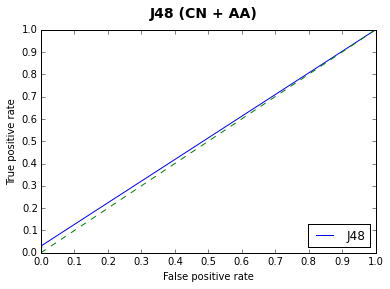

In [13]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [14]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.51506740394299111

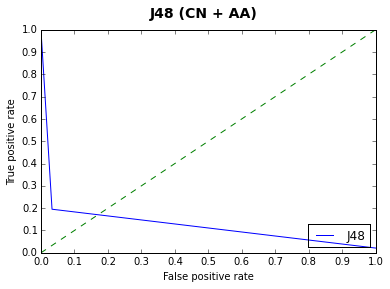

In [15]:
precision, recall, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(recall, precision, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [16]:
pr.getAreaUnderCurve((recall, precision))

0.12441094588035516

In [17]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.6081995964050293 seconds


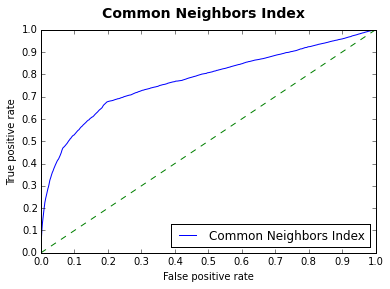

In [18]:
drawROC("Common Neighbors Index", predictions)

In [19]:
roc.getAreaUnderCurve()

0.7742771672155884

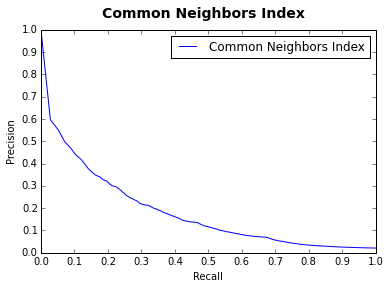

In [20]:
drawPR("Common Neighbors Index", predictions)

In [23]:
pr.getAreaUnderCurve()

0.23314200092349407

In [52]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

1.127716302871704 seconds


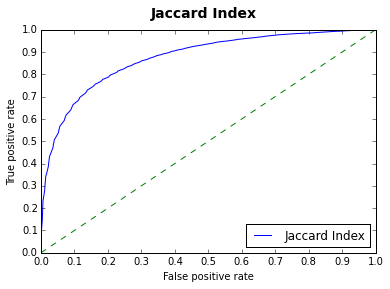

In [53]:
drawROC("Jaccard Index", predictions)

In [54]:
roc.getAreaUnderCurve()

0.8743803521148745

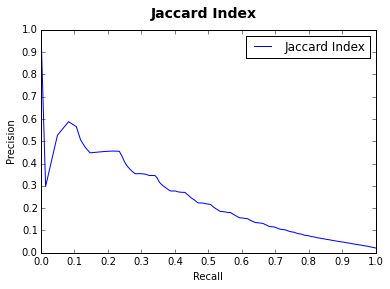

In [55]:
drawPR("Jaccard Index", predictions)

In [56]:
pr.getAreaUnderCurve()

0.24817701523216848

In [29]:
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

2.599897623062134 seconds


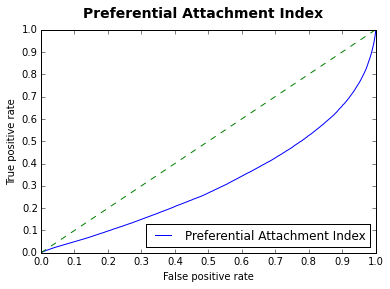

In [30]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [31]:
roc.getAreaUnderCurve()

0.31650998038264283

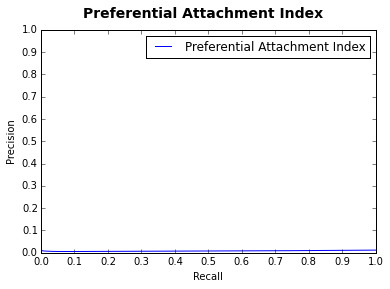

In [32]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.legend(handles=[curve])

In [33]:
pr.getAreaUnderCurve()

0.00875472096291527

In [34]:
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

4.86815333366394 seconds


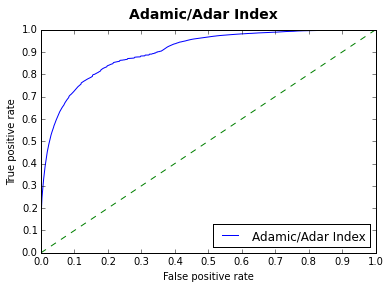

In [35]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [36]:
roc.getAreaUnderCurve()

0.9028205981073734

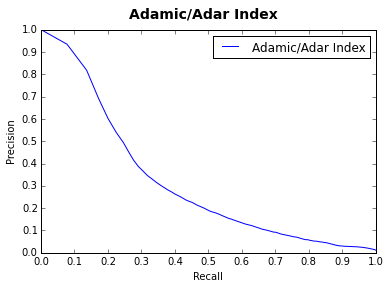

In [37]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.legend(handles=[curve])

In [38]:
pr.getAreaUnderCurve()

0.31534559800184697

In [39]:
startTime = time.time()
predictions = uDegreeIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

2.6149582862854004 seconds


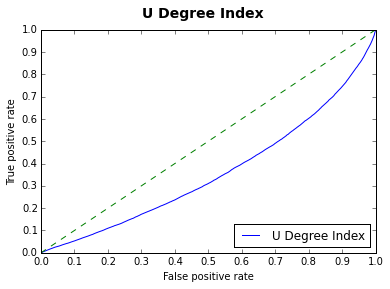

In [40]:
X, Y = roc.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [41]:
roc.getAreaUnderCurve()

0.35929239828730164

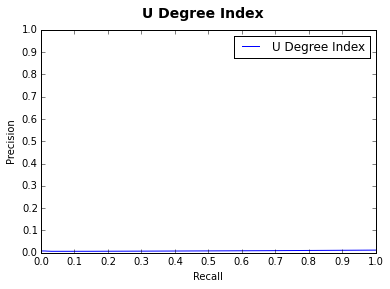

In [42]:
X, Y = pr.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.legend(handles=[curve])

In [43]:
pr.getAreaUnderCurve()

0.009134215854459029

In [44]:
startTime = time.time()
predictions = vDegreeIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

2.498599052429199 seconds


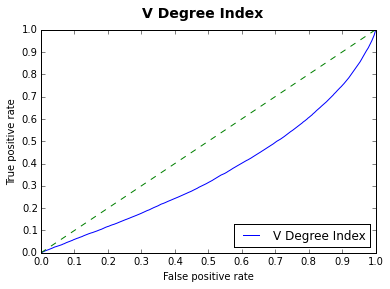

In [45]:
X, Y = roc.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [46]:
roc.getAreaUnderCurve()

0.3637527005459368

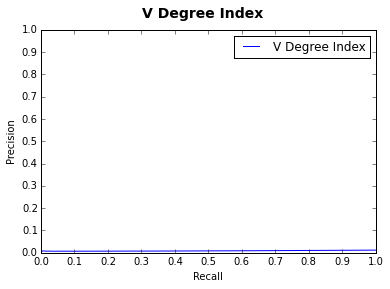

In [47]:
X, Y = pr.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.legend(handles=[curve])

In [48]:
pr.getAreaUnderCurve()

0.009152892698069293

In [49]:
startTime = time.time()
algebraicDistanceIndex.preprocess()
predictions = algebraicDistanceIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

2.7213525772094727 seconds


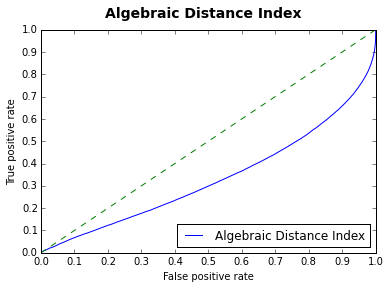

In [50]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [51]:
roc.getAreaUnderCurve()

0.33303483427855063

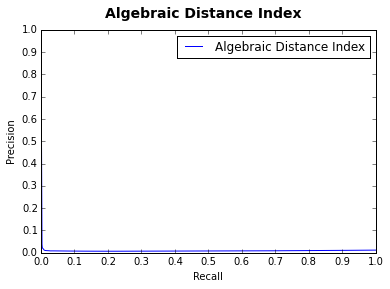

In [52]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.legend(handles=[curve])

In [53]:
pr.getAreaUnderCurve()

0.010283392912535723

In [54]:
startTime = time.time()
predictions = neighborhoodDistanceIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

5.919716835021973 seconds


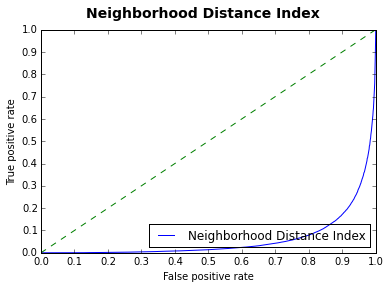

In [55]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [56]:
roc.getAreaUnderCurve()

0.0593857895611408

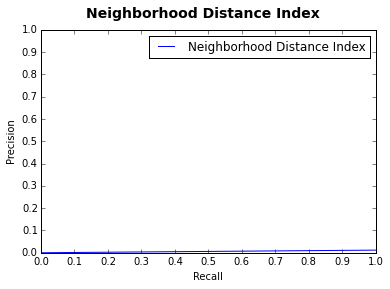

In [57]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.legend(handles=[curve])

In [58]:
pr.getAreaUnderCurve()

0.006137837443322817

In [59]:
#node = trainingGraph.randomNode()
#nodes = trainingGraph.neighbors(node)
#subGraph = graph.Subgraph().fromNodes(trainingGraph, nodes)

In [60]:
#LIST_LENGTH = len(nodes) - 1
#a = []
#color = {}
#while len(a) < LIST_LENGTH:
#    a.append(500)
#for e in nodes:
#    color[e] = len(nodes)
#a.append(2000)
#len(color)
#color[list(color)[-1]] = len(nodes) / 2
#color[list(color)[-2]] = len(nodes) / 3

In [61]:
#viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [62]:
startTime = time.time()
predictions = katzIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

301.1364517211914 seconds


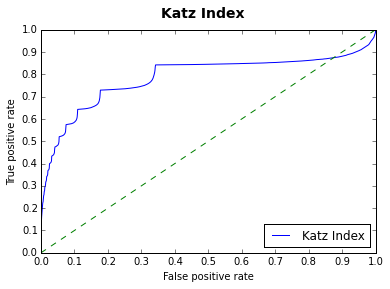

In [63]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [64]:
roc.getAreaUnderCurve()

0.7847366504133159

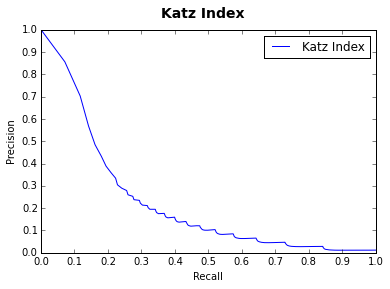

In [65]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.legend(handles=[curve])

In [66]:
pr.getAreaUnderCurve()

0.22432160622784364

In [67]:
startTime = time.time()
predictions = totalNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

5.147406101226807 seconds


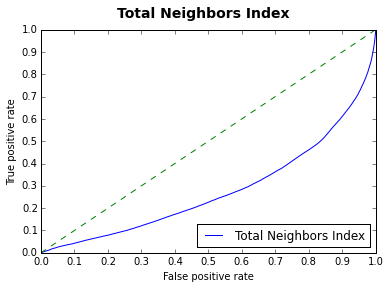

In [68]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [69]:
roc.getAreaUnderCurve()

0.27856246248455185

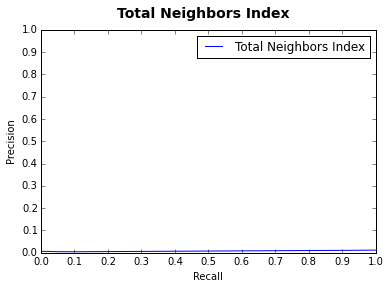

In [70]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.legend(handles=[curve])

In [71]:
pr.getAreaUnderCurve()

0.007769267439724892

In [72]:
startTime = time.time()
predictions = neighborsMeasureIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

178.28844618797302 seconds


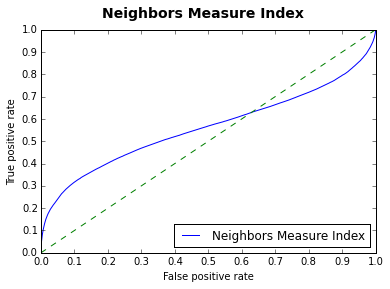

In [73]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [74]:
roc.getAreaUnderCurve()

0.5605098535129095

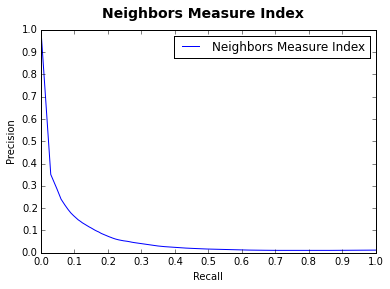

In [75]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.legend(handles=[curve])

In [76]:
pr.getAreaUnderCurve()

0.06458818725816254

In [57]:
startTime = time.time()
predictions = adjustedRandIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

189.93597793579102 seconds


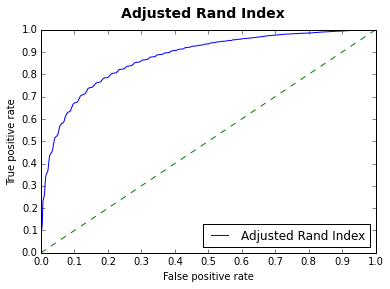

In [58]:
drawROC("Adjusted Rand Index", predictions)

In [60]:
roc.getAreaUnderCurve()

0.8749363621110597

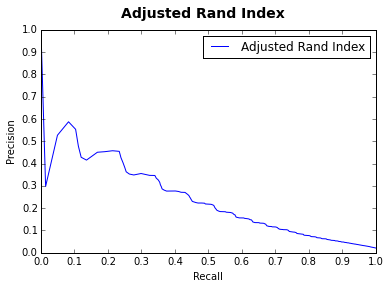

In [61]:
drawPR("Adjusted Rand Index", predictions)

In [62]:
pr.getAreaUnderCurve()

0.24432637215259756

In [21]:
startTime = time.time()
predictions = resourceAllocationIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.7658529281616211 seconds


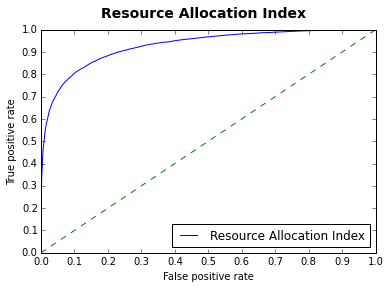

In [22]:
drawROC("Resource Allocation Index", predictions)

In [23]:
roc.getAreaUnderCurve()

0.9280528151010892

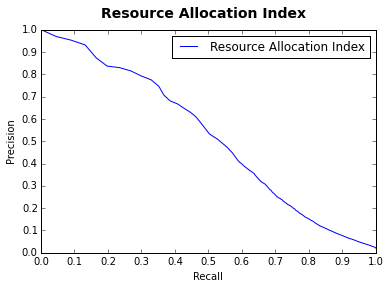

In [24]:
drawPR("Resource Allocation Index", predictions)

In [25]:
pr.getAreaUnderCurve()

0.521405639253595

In [ ]:
p1 = katzIndex.runOnParallel(missingLinks)
p2 = commonNeighborsIndex.runOnParallel(missingLinks)
p3 = jaccardIndex.runOnParallel(missingLinks)
p4 = preferentialAttachmentIndex.runOnParallel(missingLinks)
p5 = adamicAdarIndex.runOnParallel(missingLinks)
p6 = algebraicDistanceIndex.runOnParallel(missingLinks)
p7 = neighborhoodDistanceIndex.runOnParallel(missingLinks)
p8 = neighborsMeasureIndex.runOnParallel(missingLinks)
ins=["Katz", "Common Neighbors", "Jaccard", "Preferential Attachment", "Adamic/Adar", "Algebraic Distance", "Neighborhood Distance", "Neighbors-Measure"]
preds=[p1, p2, p3, p4, p5, p6, p7, p8]
drawROCs("Polblogs", indexNames=ins, predictions=preds)